# Introduction

This notebook is a demo of the Dynamic Tariff Analysis algorithm (version 2) on EnergyID.

We try to answer the question: "Is a dynamic tariff advantageous for me?".
We do this by comparing billing based on SMR3 meter readings (15 minute granularity), also known as a dynamic tariff,
with billing based on (virtualised) SMR2 meter readings (eg. the monthly sum of the SMR3 readings).

By re-dividing the monthly sum of the SMR3 readings back into 15 minute intervals, using the RLP and SPP profiles, we create a "15 minute SMR2" series, that can easily be compared with the SMR3 series.

## Imports

In [1]:
import pandas as pd

from openenergyid.dyntar import (
    DynamicTariffAnalysisInput,
    DynamicTariffAnalysisOutput,
    calculate_dyntar_columns,
    summarize_result,
)

import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt

## Input Data

The input data is a JSON file, containing a DynamicTariffAnalysisInput object.

The object needs to have following columns in 15-minute intervals:
- `electricity_delivered`
- `electricity_exported`
- `price_electricity_delivered`
- `price_electricity_exported`
- `RLP`
- `SPP`

In [2]:
data = DynamicTariffAnalysisInput.from_json(path="data/dyntar/sample.json")

df = data.to_pandas()

df

,electricity_delivered,electricity_exported,price_electricity_delivered,price_electricity_exported,RLP,SPP
2023-12-31 23:00:00+00:00,0.023,0.0,0.004102,-0.003915,0.000041,0.0
2023-12-31 23:15:00+00:00,0.026,0.0,0.004102,-0.003915,0.000041,0.0
2023-12-31 23:30:00+00:00,0.020,0.0,0.004102,-0.003915,0.000040,0.0
2023-12-31 23:45:00+00:00,0.029,0.0,0.004102,-0.003915,0.000039,0.0
2024-01-01 00:00:00+00:00,0.020,0.0,0.004010,-0.003992,0.000038,0.0
...,...,...,...,...,...,...
2024-04-18 20:00:00+00:00,0.115,0.0,0.095627,0.072355,0.000032,0.0
2024-04-18 20:15:00+00:00,0.140,0.0,0.095627,0.072355,0.000032,0.0
2024-04-18 20:30:00+00:00,0.116,0.0,0.095627,0.072355,0.000032,0.0
2024-04-18 20:45:00+00:00,0.131,0.0,0.095627,0.072355,0.000031,0.0


## Analysis

We calculate a bunch of extra columns

- From the 2 electricity columns, `electricity_delivered` and `electricity_exported`, we make 4:
    - `electricity_delivered_smr3` and `electricity_exported_smr3` are the original SMR3 readings
    - `electricity_delivered_smr2` and `electricity_exported_smr2` are the virtualised SMR2 readings
- We calculate the cost for each of these 4 columns, by multiplying the electricity with the price.
- We add the RLP and SPP weighted prices as well.
- We calculate the Heatmap Scores according to the formula: TODO

In [3]:
df = calculate_dyntar_columns(df)

In [4]:
df

,electricity_delivered_smr3,electricity_exported_smr3,price_electricity_delivered,price_electricity_exported,RLP,SPP,electricity_delivered_smr2,electricity_exported_smr2,cost_electricity_delivered_smr2,cost_electricity_delivered_smr3,cost_electricity_exported_smr2,cost_electricity_exported_smr3,rlp_weighted_price_delivered,spp_weighted_price_exported,heatmap_delivered,heatmap_exported,heatmap_total,heatmap_delivered_description,heatmap_exported_description,heatmap_total_description
2023-12-31 23:00:00+00:00,0.023,0.0,0.004102,-0.003915,0.000041,0.0,0.025193,NaN,0.000103,0.000094,NaN,0.0,0.004102,NaN,-0.000000,0.0,0.000000,0,0,0
2023-12-31 23:15:00+00:00,0.026,0.0,0.004102,-0.003915,0.000041,0.0,0.024818,NaN,0.000102,0.000107,NaN,0.0,0.004102,NaN,0.000000,0.0,0.000000,0,0,0
2023-12-31 23:30:00+00:00,0.020,0.0,0.004102,-0.003915,0.000040,0.0,0.024259,NaN,0.000100,0.000082,NaN,0.0,0.004102,NaN,-0.000000,0.0,0.000000,0,0,0
2023-12-31 23:45:00+00:00,0.029,0.0,0.004102,-0.003915,0.000039,0.0,0.023730,NaN,0.000097,0.000119,NaN,0.0,0.004102,NaN,0.000000,0.0,0.000000,0,0,0
2024-01-01 00:00:00+00:00,0.020,0.0,0.004010,-0.003992,0.000038,0.0,0.133335,0.0,0.000535,0.000080,0.0,0.0,0.086561,0.062453,-0.009356,0.0,-0.009356,4,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-18 20:00:00+00:00,0.115,0.0,0.095627,0.072355,0.000032,0.0,0.039762,0.0,0.003802,0.010997,-0.0,-0.0,0.046355,0.019040,-0.003707,-0.0,-0.003707,1,0,1
2024-04-18 20:15:00+00:00,0.140,0.0,0.095627,0.072355,0.000032,0.0,0.040024,0.0,0.003827,0.013388,-0.0,-0.0,0.046355,0.019040,-0.004926,-0.0,-0.004926,1,0,1
2024-04-18 20:30:00+00:00,0.116,0.0,0.095627,0.072355,0.000032,0.0,0.039903,0.0,0.003816,0.011093,-0.0,-0.0,0.046355,0.019040,-0.003749,-0.0,-0.003749,1,0,1
2024-04-18 20:45:00+00:00,0.131,0.0,0.095627,0.072355,0.000031,0.0,0.038904,0.0,0.003720,0.012527,-0.0,-0.0,0.046355,0.019040,-0.004538,-0.0,-0.004538,1,0,1


In [5]:
summarize_result(df)

cost_electricity_delivered_smr2    75.351600
cost_electricity_delivered_smr3    83.939318
cost_electricity_exported_smr2     -9.485280
cost_electricity_exported_smr3     -8.439498
cost_electricity_total_smr2        65.866320
cost_electricity_total_smr3        75.499819
ratio                               0.113553
dtype: float64

In [6]:
output_model = DynamicTariffAnalysisOutput.from_pandas(df)

output_model.to_json(path="data/dyntar/sample_output.json", indent=4)

# Visualisation

In [7]:
from openenergyid.dyntar.const import (
    ELECTRICITY_DELIVERED_SMR3,
    ELECTRICITY_EXPORTED_SMR3,
    ELECTRICITY_DELIVERED_SMR2,
    ELECTRICITY_EXPORTED_SMR2,
    COST_ELECTRICITY_DELIVERED_SMR2,
    COST_ELECTRICITY_EXPORTED_SMR2,
    COST_ELECTRICITY_DELIVERED_SMR3,
    COST_ELECTRICITY_EXPORTED_SMR3,
    HEATMAP_TOTAL,
    HEATMAP_DELIVERED,
    HEATMAP_EXPORTED,
)

# Detail Graphs for one month

To show the difference between the SMR2 and SMR3 profiles, we show the following graphs

In [8]:
result_slice = df.truncate(
    before=pd.Timestamp("2024-03-01", tz="Europe/Brussels"),
    after=pd.Timestamp("2024-03-31T23:45:00", tz="Europe/Brussels"),
)

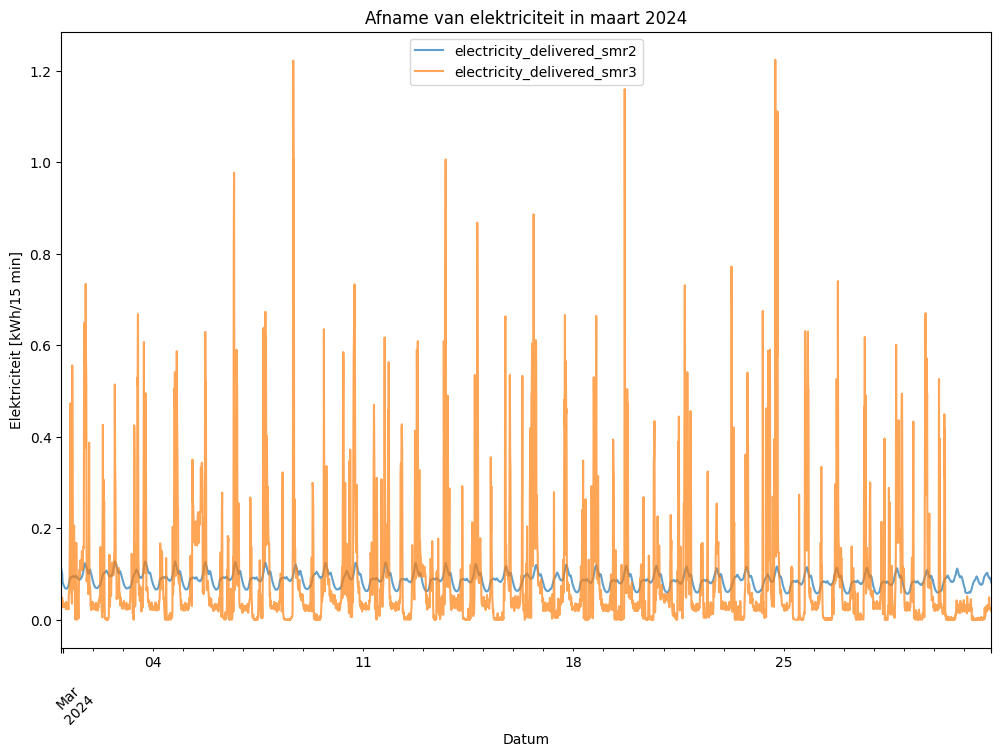

In [9]:
# Show line graphs of electricty delivered for SMR2 and SMR3

fig, ax = plt.subplots()
# Set the size of the figure
fig.set_size_inches(12, 8)

# Give both lines a bit of transparency
result_slice[[ELECTRICITY_DELIVERED_SMR2, ELECTRICITY_DELIVERED_SMR3]].plot(ax=ax, alpha=0.7)

# Set the labels
ax.set_ylabel("Elektriciteit [kWh/15 min]")
ax.set_xlabel("Datum")

# horizontal ticks
plt.xticks(rotation=45)

# Title of the graph: "Afname van elektriciteit in maart 2024"
plt.title("Afname van elektriciteit in maart 2024")


plt.show()

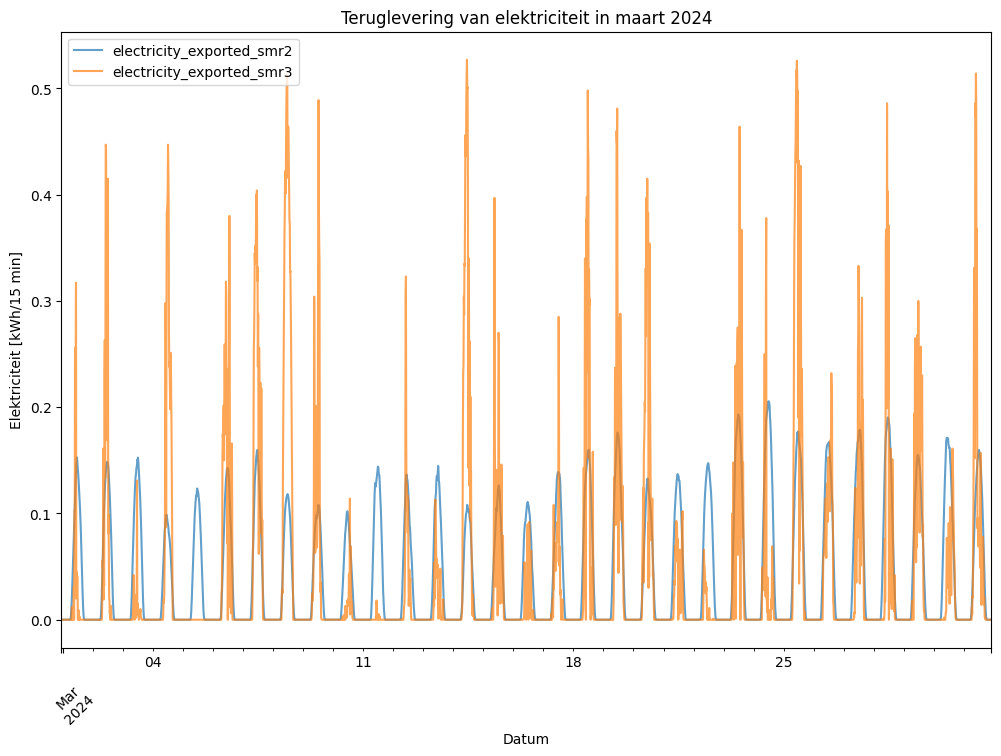

In [10]:
# Show line graphs of electricty exported for SMR2 and SMR3

fig, ax = plt.subplots()
# Set the size of the figure
fig.set_size_inches(12, 8)

# Give both lines a bit of transparency
result_slice[[ELECTRICITY_EXPORTED_SMR2, ELECTRICITY_EXPORTED_SMR3]].plot(ax=ax, alpha=0.7)

# Set the labels
ax.set_ylabel("Elektriciteit [kWh/15 min]")
ax.set_xlabel("Datum")

# horizontal ticks
plt.xticks(rotation=45)

# Title of the graph: "Teruglevering van elektriciteit in maart 2024"
plt.title("Teruglevering van elektriciteit in maart 2024")

plt.show()

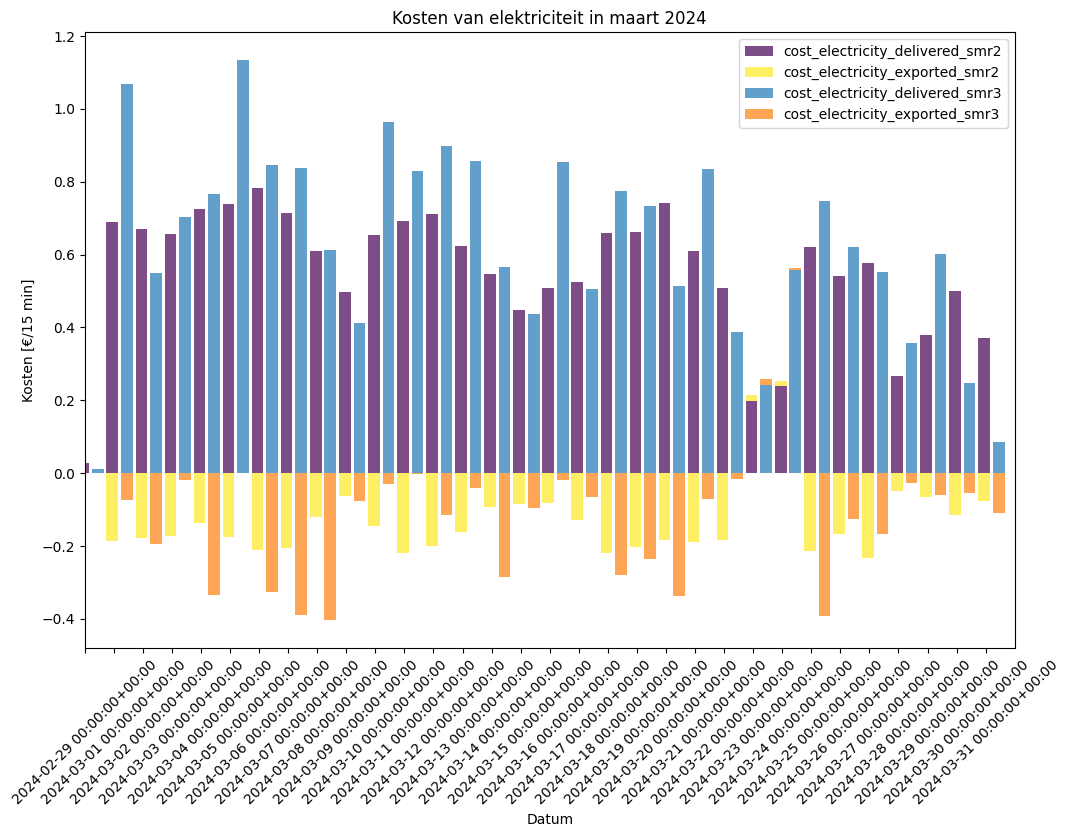

In [11]:
# Show a bar graph of the costs of electricity delivered and exported for SMR2 and SMR3
# Stack the cost for exported electricity under the cost for delivered electricity

fig, ax = plt.subplots()

# Set the size of the figure
fig.set_size_inches(12, 8)

# Create a stacked bar graph

slice = (
    result_slice[
        [
            COST_ELECTRICITY_DELIVERED_SMR2,
            COST_ELECTRICITY_DELIVERED_SMR3,
            COST_ELECTRICITY_EXPORTED_SMR2,
            COST_ELECTRICITY_EXPORTED_SMR3,
        ]
    ]
    .resample("D")
    .sum()
)

# Offset SMR2 to the left and SMR3 to the right
slice[[COST_ELECTRICITY_DELIVERED_SMR2, COST_ELECTRICITY_EXPORTED_SMR2]].plot(
    kind="bar", stacked=True, ax=ax, alpha=0.7, position=0.5, colormap="viridis"
)
slice[[COST_ELECTRICITY_DELIVERED_SMR3, COST_ELECTRICITY_EXPORTED_SMR3]].plot(
    kind="bar", stacked=True, ax=ax, alpha=0.7, position=-0.5
)

# Make the bars thinner to make them more distinguishable
for bar in ax.patches:
    bar.set_width(0.4)

# Set the labels

ax.set_ylabel("Kosten [€/15 min]")

ax.set_xlabel("Datum")

# horizontal ticks

plt.xticks(rotation=45)

# Title of the graph: "Kosten van elektriciteit in maart 2024"

plt.title("Kosten van elektriciteit in maart 2024")

plt.show()

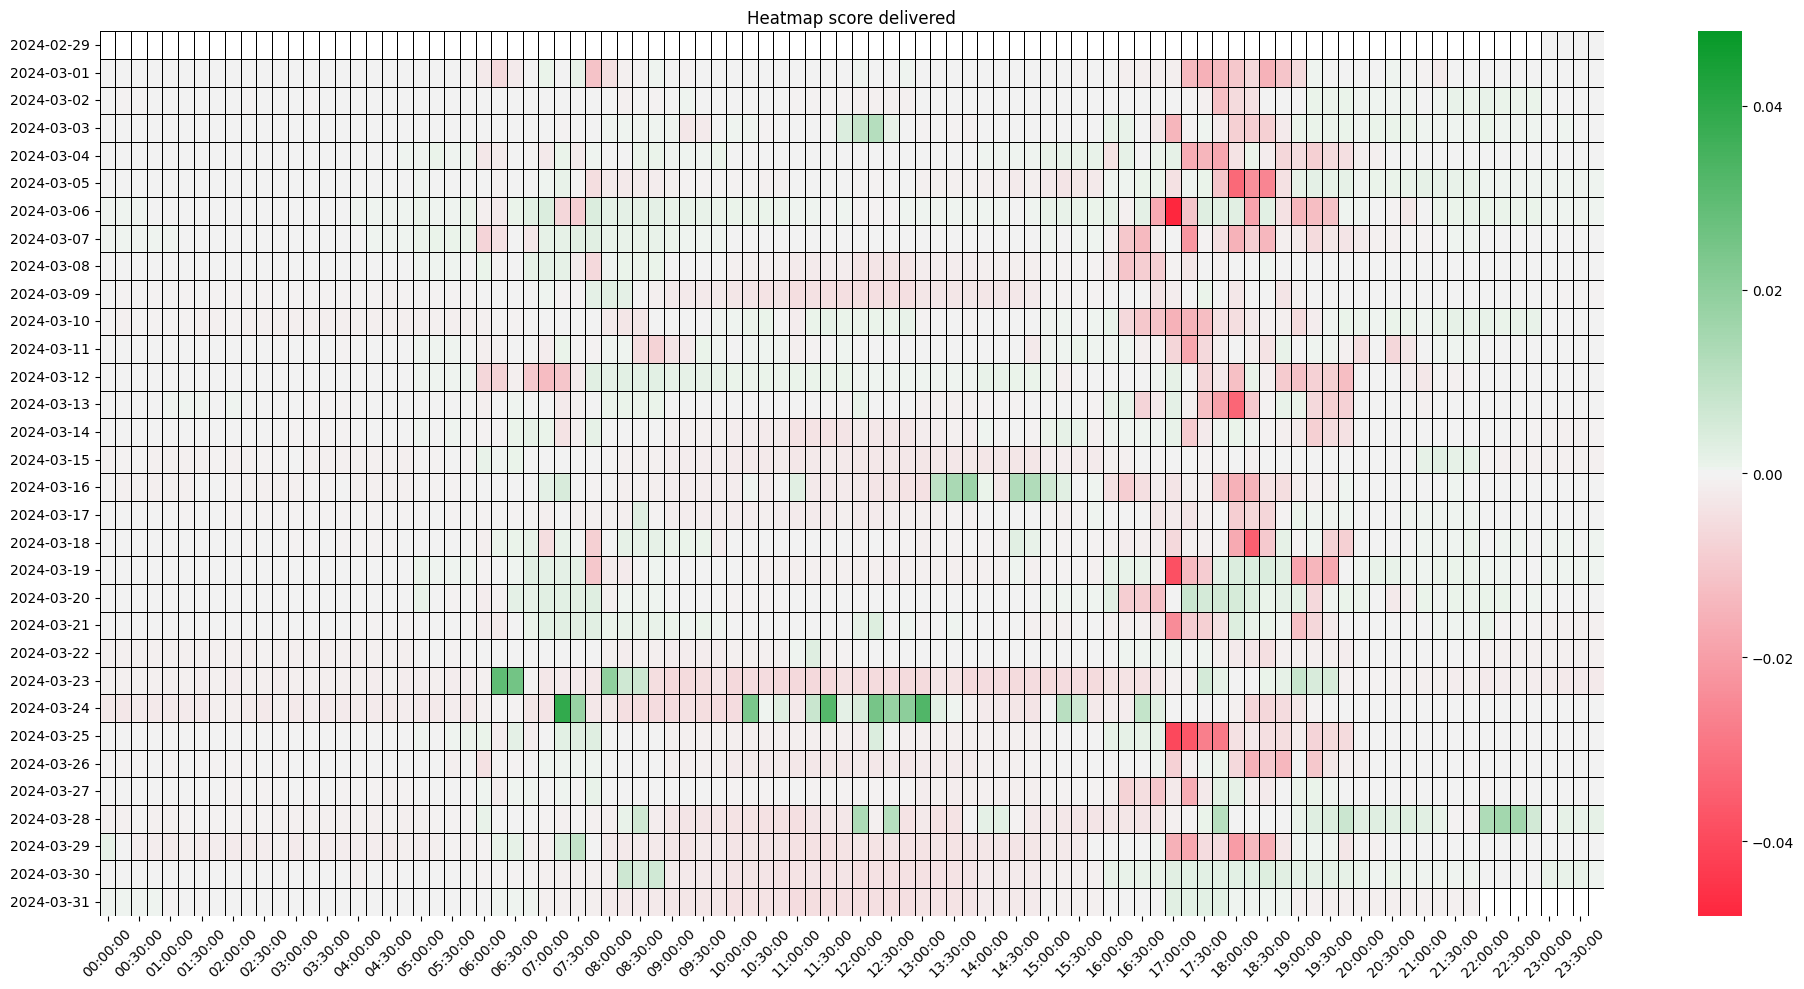

In [12]:
heatmap_plot = result_slice[HEATMAP_DELIVERED].to_frame()

heatmap_plot["date"] = heatmap_plot.index.date
heatmap_plot["time"] = heatmap_plot.index.time

heatmap_plot = heatmap_plot.pivot(index="date", columns="time", values=HEATMAP_DELIVERED)

min_ = heatmap_plot.min().min()
max = heatmap_plot.max().max()

abs_max = max if abs(max) > abs(min_) else abs(min_)

# Plot the carpetplot

fig, ax = plt.subplots()

# Set figsize
fig.set_size_inches(20, 10)

# Choose a colormap that goes from red to green, with 0 in the middle

rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=55, sep=3, as_cmap=True)
divnorm = TwoSlopeNorm(vmin=abs_max * -1, vcenter=0, vmax=abs_max)
sns.heatmap(
    heatmap_plot, cmap=rdgn, norm=divnorm, linewidths=0.5, linecolor="black", cbar=True, ax=ax
)

plt.title("Heatmap score delivered")
plt.ylabel(None)
plt.xlabel(None)

# x-axis label rotated

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

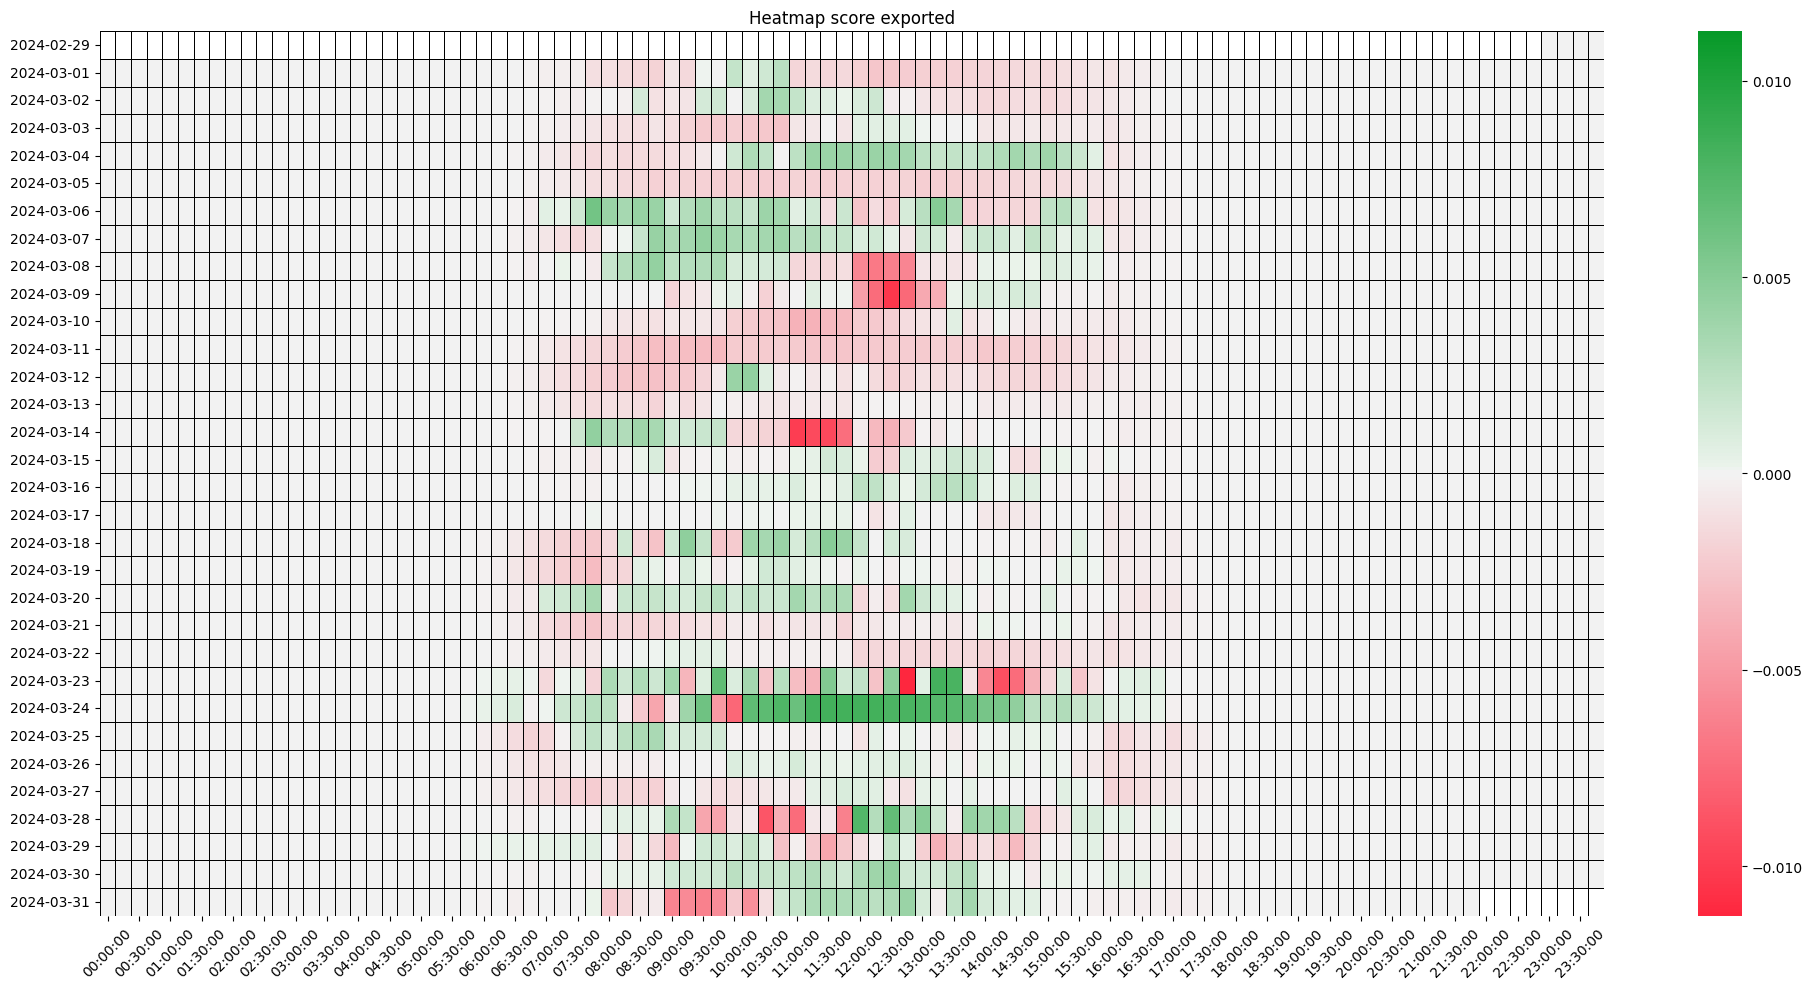

In [13]:
heatmap_plot = result_slice[HEATMAP_EXPORTED].to_frame()

heatmap_plot["date"] = heatmap_plot.index.date
heatmap_plot["time"] = heatmap_plot.index.time

heatmap_plot = heatmap_plot.pivot(index="date", columns="time", values=HEATMAP_EXPORTED)

min_ = heatmap_plot.min().min()
max = heatmap_plot.max().max()

abs_max = max if abs(max) > abs(min_) else abs(min_)

# Plot the carpetplot

fig, ax = plt.subplots()

# Set figsize
fig.set_size_inches(20, 10)

# Choose a colormap that goes from red to green, with 0 in the middle

rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=55, sep=3, as_cmap=True)
divnorm = TwoSlopeNorm(vmin=abs_max * -1, vcenter=0, vmax=abs_max)
sns.heatmap(
    heatmap_plot, cmap=rdgn, norm=divnorm, linewidths=0.5, linecolor="black", cbar=True, ax=ax
)

plt.title("Heatmap score exported")
plt.ylabel(None)
plt.xlabel(None)

# x-axis label rotated

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

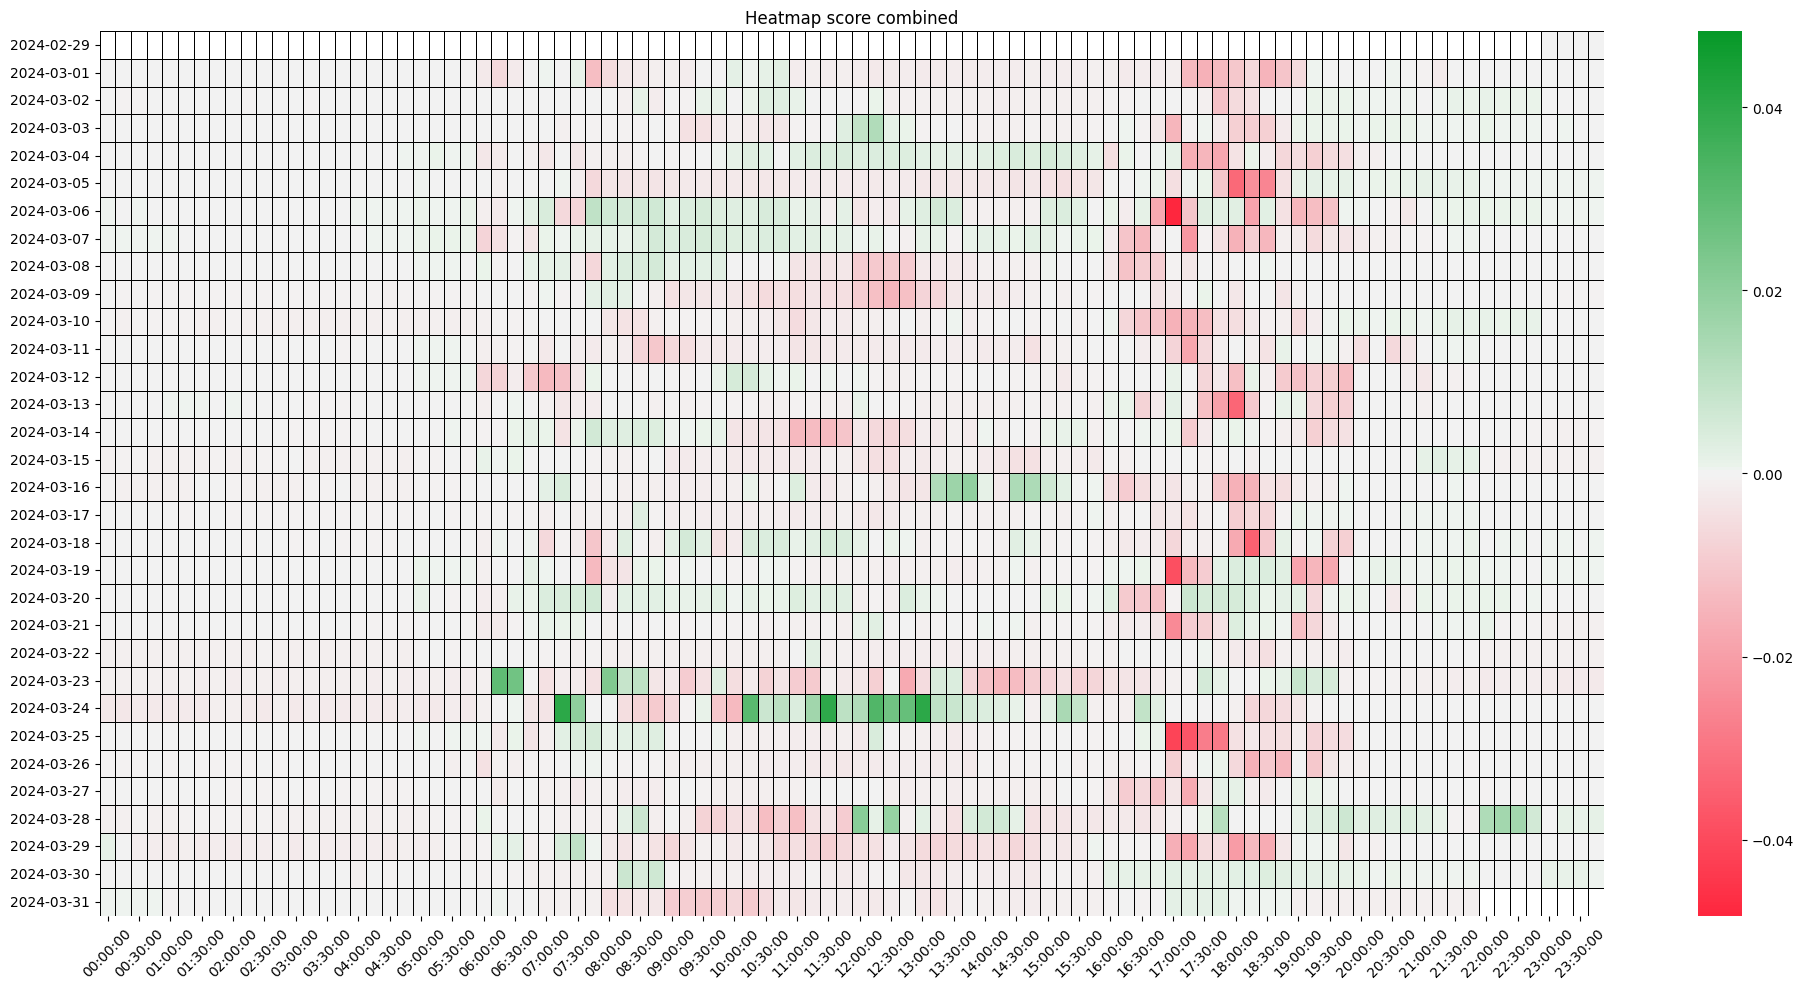

In [14]:
heatmap_plot = result_slice[HEATMAP_TOTAL].to_frame()

heatmap_plot["date"] = heatmap_plot.index.date
heatmap_plot["time"] = heatmap_plot.index.time

heatmap_plot = heatmap_plot.pivot(index="date", columns="time", values=HEATMAP_TOTAL)

min_ = heatmap_plot.min().min()
max = heatmap_plot.max().max()

abs_max = max if abs(max) > abs(min_) else abs(min_)

# Plot the carpetplot

fig, ax = plt.subplots()

# Set figsize
fig.set_size_inches(20, 10)

# Choose a colormap that goes from red to green, with 0 in the middle

rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=55, sep=3, as_cmap=True)
divnorm = TwoSlopeNorm(vmin=abs_max * -1, vcenter=0, vmax=abs_max)
sns.heatmap(
    heatmap_plot, cmap=rdgn, norm=divnorm, linewidths=0.5, linecolor="black", cbar=True, ax=ax
)

plt.title("Heatmap score combined")
plt.ylabel(None)
plt.xlabel(None)

# x-axis label rotated

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()